Valori minimi per ogni variabile:
Anthropogenic Forcing                  -0.69100
Temperature Anomaly                   285.52747
CO2                                   354.03884
CH4                                  1716.65150
Victims Without External Causes    117241.00000
Respiratory Diseases               158836.00000
Digestive Diseases                 178111.00000
Mental and Behavioural Disorder     96920.00000
Nervous System Diseases             58167.00000
dtype: float64

Valori massimi per ogni variabile:
Anthropogenic Forcing                   2.57400
Temperature Anomaly                   287.85883
CO2                                   411.42982
CH4                                  1898.52600
Victims Without External Causes    252967.00000
Respiratory Diseases               228324.00000
Digestive Diseases                 197135.00000
Mental and Behavioural Disorder    371505.00000
Nervous System Diseases            185521.00000
dtype: float64
Epoch [1/150], Loss: 1.0865955352783

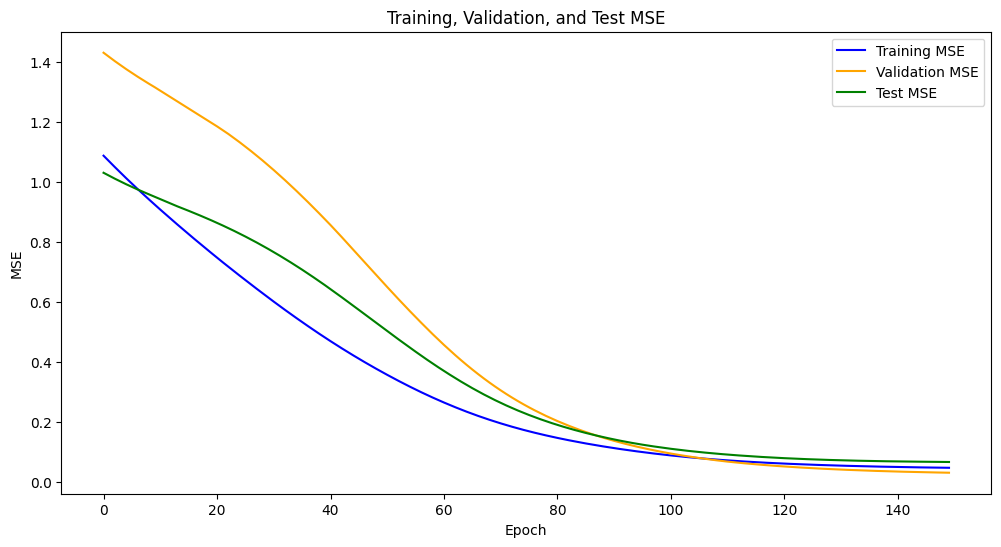

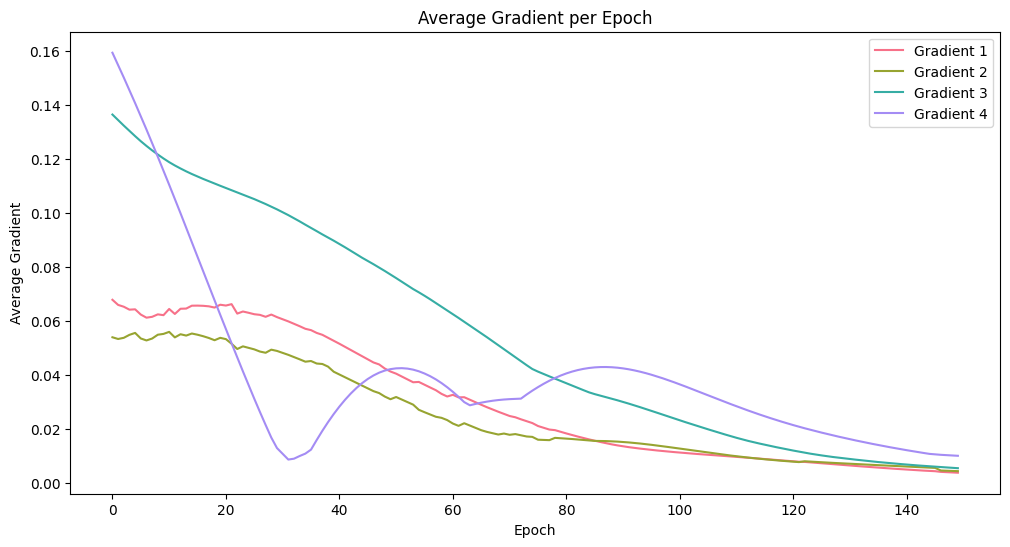

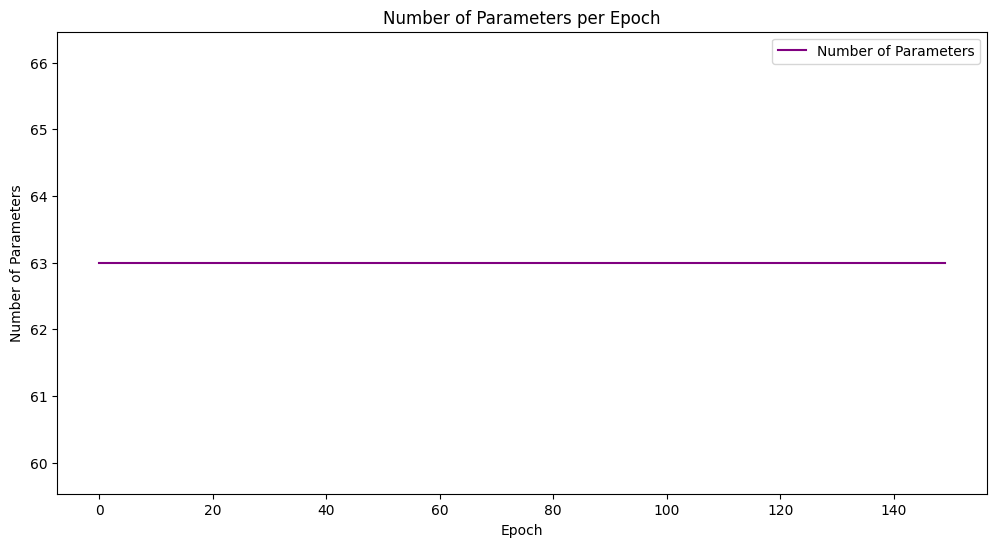

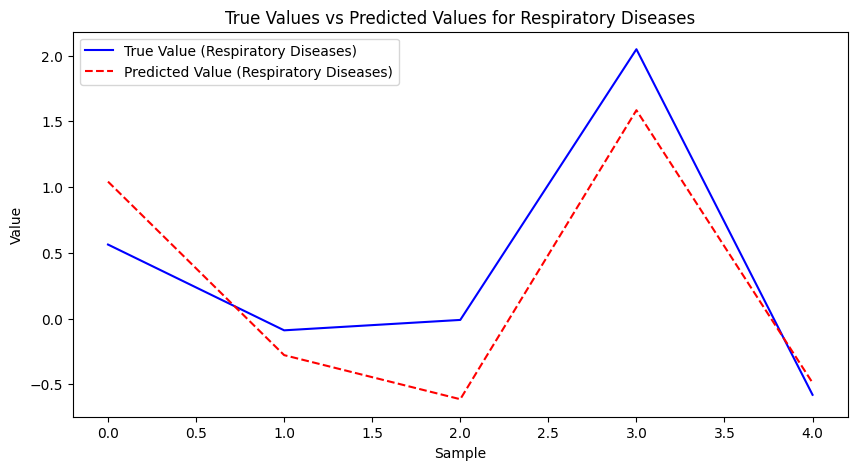

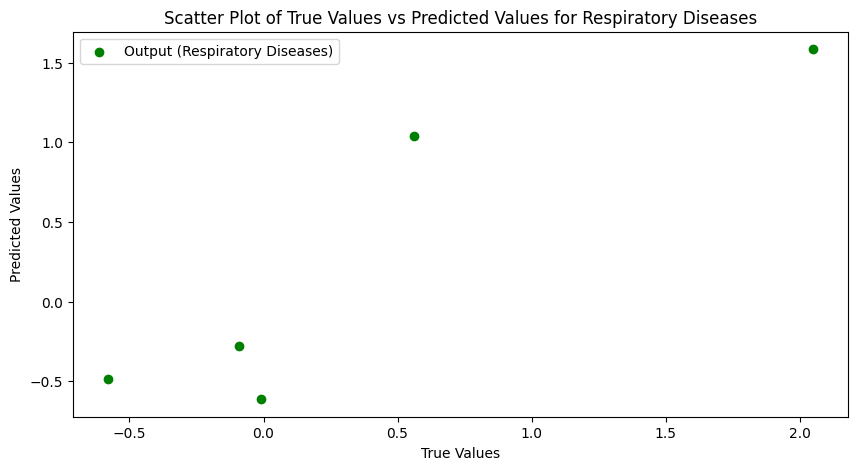

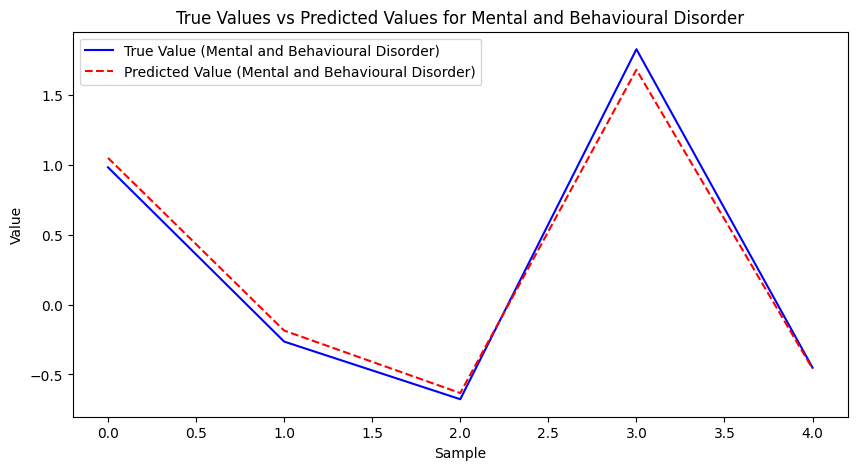

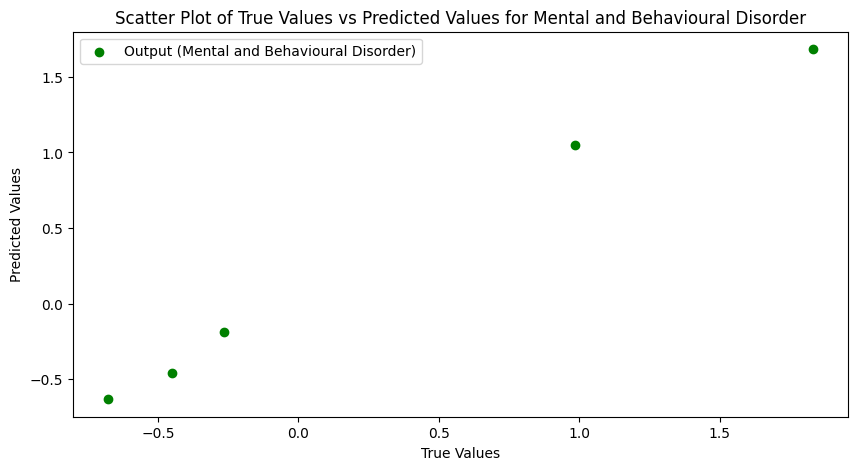

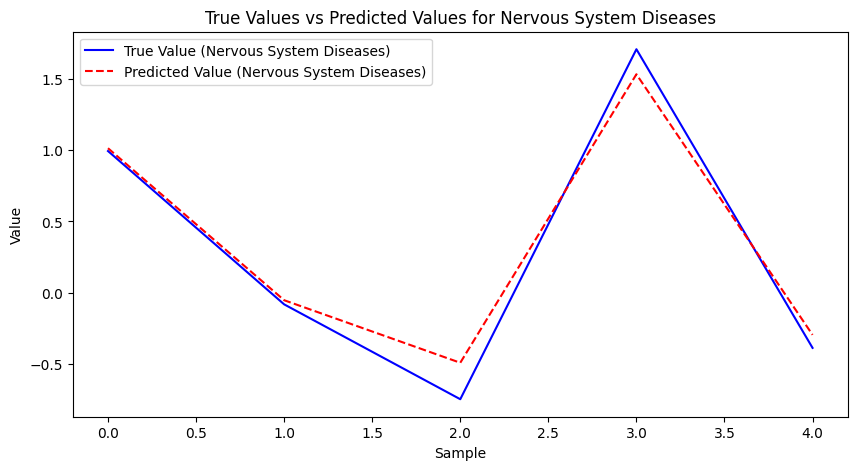

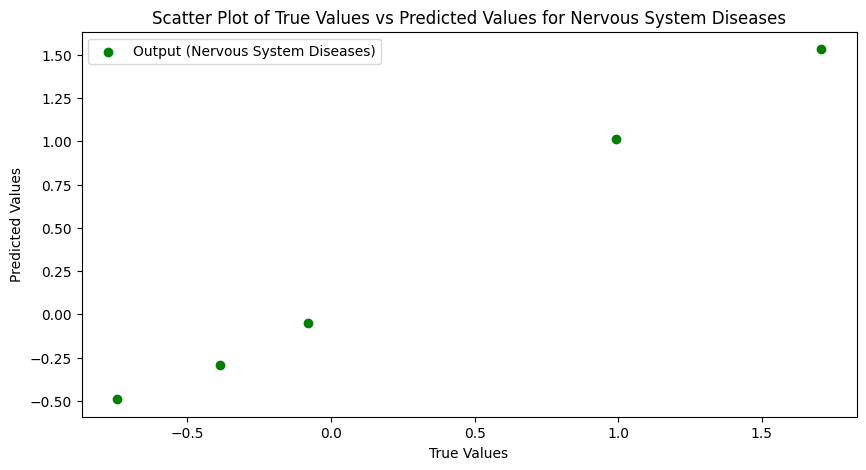

Training Error Variance for Respiratory Diseases: 0.11292342096567154
Validation Error Variance for Respiratory Diseases: 0.057532794773578644
Test Error Variance for Respiratory Diseases: 0.15152382850646973
Training Error Variance for Mental and Behavioural Disorder: 0.008064789697527885
Validation Error Variance for Mental and Behavioural Disorder: 0.008266767486929893
Test Error Variance for Mental and Behavioural Disorder: 0.0068287840113043785
Training Error Variance for Nervous System Diseases: 0.01752297766506672
Validation Error Variance for Nervous System Diseases: 0.02346106618642807
Test Error Variance for Nervous System Diseases: 0.019214849919080734
Correlation coefficient for Respiratory Diseases: 0.9064444628759813
Correlation coefficient for Mental and Behavioural Disorder: 0.9976361194757638
Correlation coefficient for Nervous System Diseases: 0.9972587006967131


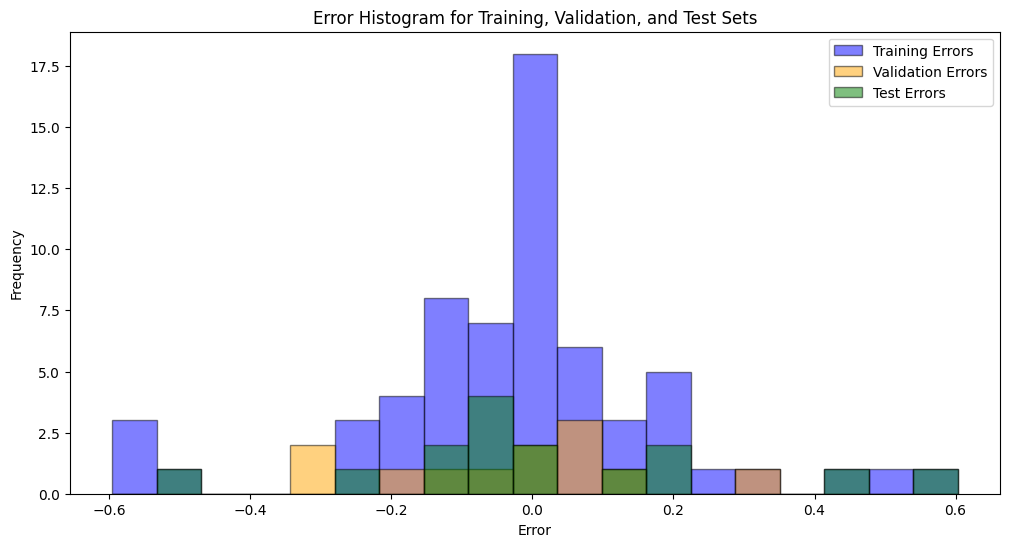

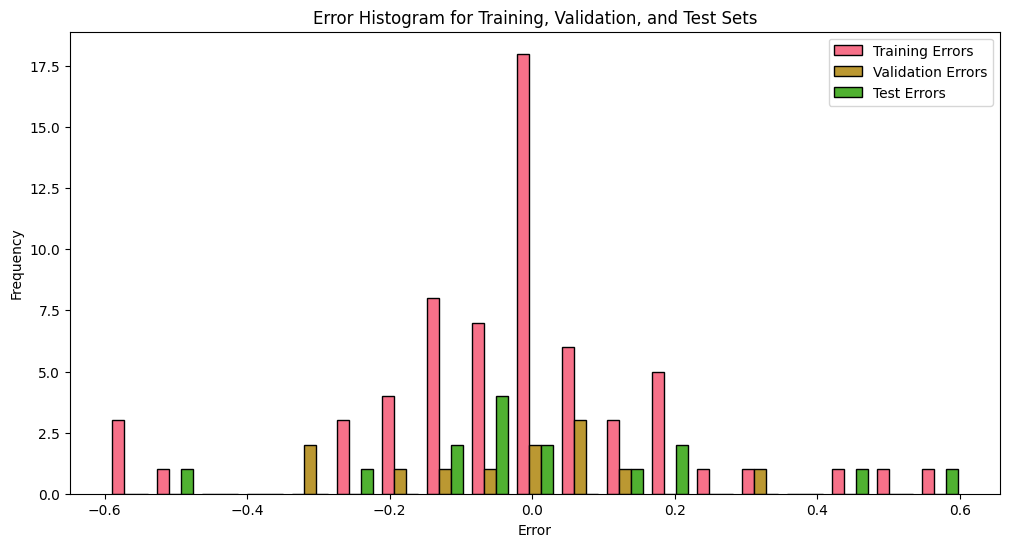

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Impostazione della palette di colori
sns.set_palette("husl")

# Lettura del dataset da CSV
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')

# Nomi delle colonne
input_columns = ['CO2', 'CH4']  # 3ª e 4ª colonna
output_columns = ['Respiratory Diseases', 'Mental and Behavioural Disorder', 'Nervous System Diseases']

# Stampa dei valori minimi e massimi per ogni variabile
print("Valori minimi per ogni variabile:")
print(df.min())

print("\nValori massimi per ogni variabile:")
print(df.max())

# Separazione delle caratteristiche e delle etichette
X = df[input_columns].values
y = df[output_columns].values

# Normalizzazione dei dati climatici
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Normalizzazione delle etichette
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

# Suddivisione dei dati in training (70%), validazione (15%) e test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Conversione a tensori PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Definizione del modello con dropout
class FeedforwardNN(nn.Module):
    def __init__(self):
        super(FeedforwardNN, self).__init__()
        self.hidden = nn.Linear(2, 10)  # 2 input features
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(10, 3)  # 3 output features

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.dropout(x)  # Aggiunta del dropout
        x = self.output(x)  # Usiamo linear per output continuo
        return x

model = FeedforwardNN()

# Definizione della funzione di perdita e dell'ottimizzatore con regolarizzazione L2
criterion = nn.MSELoss()
learning_rate = 0.003  # Ridotto il learning rate
weight_decay = 1e-4    # Coefficiente di regolarizzazione L2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Callback per Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Inizializzazione di Early Stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

# Funzione per calcolare il numero di parametri del modello
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Addestramento del modello
num_epochs = 150
train_losses = []
val_losses = []
test_losses = []
gradients = []
num_parameters = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Memorizzazione delle perdite di addestramento
    train_losses.append(loss.item())

    # Memorizzazione dei gradienti medi
    avg_grads = [torch.mean(torch.abs(param.grad)).item() for param in model.parameters() if param.grad is not None]
    gradients.append(avg_grads)

    # Memorizzazione del numero di parametri
    num_parameters.append(count_parameters(model))

    # Valutazione del modello
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Val Loss: {val_loss.item()}, Test Loss: {test_loss.item()}, Params: {num_parameters[-1]}')

    # Check per early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Plot delle perdite di addestramento, validazione e test
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training MSE', color='blue')
plt.plot(val_losses, label='Validation MSE', color='orange')
plt.plot(test_losses, label='Test MSE', color='green')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training, Validation, and Test MSE')
plt.legend()
plt.show()

# Plot dei gradienti
gradients = np.array(gradients)
plt.figure(figsize=(12, 6))
colors = sns.color_palette("husl", gradients.shape[1])
for i in range(gradients.shape[1]):
    plt.plot(gradients[:, i], label=f'Gradient {i+1}', color=colors[i])
plt.xlabel('Epoch')
plt.ylabel('Average Gradient')
plt.title('Average Gradient per Epoch')
plt.legend()
plt.show()

# Plot del numero di parametri
plt.figure(figsize=(12, 6))
plt.plot(num_parameters, label='Number of Parameters', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters per Epoch')
plt.legend()
plt.show()

# Plot separato per ogni variabile di output con nomi delle colonne
with torch.no_grad():
    y_pred = model(X_test).numpy()

for i, col in enumerate(output_columns):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test[:, i], label=f'True Value ({col})', color='blue')
    plt.plot(y_pred[:, i], '--', label=f'Predicted Value ({col})', color='red')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title(f'True Values vs Predicted Values for {col}')
    plt.legend()
    plt.show()

    # Plot di dispersione delle predizioni vs i valori reali
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test[:, i], y_pred[:, i], label=f'Output ({col})', color='green')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Scatter Plot of True Values vs Predicted Values for {col}')
    plt.legend()
    plt.show()

# Calcolo degli errori (target - output) per training, validazione e test
model.eval()
with torch.no_grad():
    train_pred = model(X_train).numpy()
    val_pred = model(X_val).numpy()
    test_pred = model(X_test).numpy()

train_errors = y_train.numpy() - train_pred
val_errors = y_val.numpy() - val_pred
test_errors = y_test.numpy() - test_pred

# Calcolo della varianza degli errori per ogni variabile di output
train_variances = np.var(train_errors, axis=0)
val_variances = np.var(val_errors, axis=0)
test_variances = np.var(test_errors, axis=0)

for i, col in enumerate(output_columns):
    print(f'Training Error Variance for {col}: {train_variances[i]}')
    print(f'Validation Error Variance for {col}: {val_variances[i]}')
    print(f'Test Error Variance for {col}: {test_variances[i]}')

# Calcolo del coefficiente di correlazione per ogni variabile di output
for i, col in enumerate(output_columns):
    corr = np.corrcoef(y_test[:, i], y_pred[:, i])[0, 1]
    print(f'Correlation coefficient for {col}: {corr}')

# Definizione dei bin comuni
all_train_errors = train_errors.flatten()
all_val_errors = val_errors.flatten()
all_test_errors = test_errors.flatten()

bins = np.linspace(min(all_train_errors.min(), all_val_errors.min(), all_test_errors.min()),
                   max(all_train_errors.max(), all_val_errors.max(), all_test_errors.max()), 20)

# Plot dell'istogramma totale degli errori per training, validazione e test
plt.figure(figsize=(12, 6))
plt.hist(all_train_errors, bins=bins, alpha=0.5, label='Training Errors', color='blue', edgecolor='black')
plt.hist(all_val_errors, bins=bins, alpha=0.5, label='Validation Errors', color='orange', edgecolor='black')
plt.hist(all_test_errors, bins=bins, alpha=0.5, label='Test Errors', color='green', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Histogram for Training, Validation, and Test Sets')
plt.legend()
plt.show()

# Plot dell'istogramma con i tre valori sullo stesso bin in colonna
plt.figure(figsize=(12, 6))
plt.hist([all_train_errors, all_val_errors, all_test_errors], bins=bins, label=['Training Errors', 'Validation Errors', 'Test Errors'], edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Histogram for Training, Validation, and Test Sets')
plt.legend()
plt.show()

